## Advanced Algorithmic Trading DT - V4

### Updates from Last Version
- Fixed Train/Test split
- Fixed R-Squared calculation for linear model
- Do for: 
    - Random Forest
    - Bagging
    - Boosting
    - Linear Regression  
    


#### Import Packages

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math

import datetime
import gc

from sklearn.ensemble import (BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

from technical_indicators import * # import all function

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
#import parfit as pf
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression


#### Set Parameters

In [4]:
# Set the random seed, number of estimators and the "step factor" used to plot the graph of MSE for each method
random_state = 42  # Seed
n_jobs = -1 # -1 --> all Processors # Parallelisation factor for bagging, random forests (controls the number of processor cores used)
n_estimators = 200 # total number of estimators ot use in the MSE graph
step_factor = 10 # controls cranularity of calculation by stepping through the number of estimators
axis_step = int(n_estimators / step_factor) # 1000/10 = 100 separate calculations will be performed for each of the 3 ensebmle methods


#### Read in Data via GitHub URL

In [37]:
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)


***
## Clean Data & Create Technical Indicator Variables

- Create Deep copy of dataframe
- Use Adjusted Close Data
- Drop Close 
- Rename "Adj. Close" as "Close"
- Create Lagged Features
- Drop NaN
- Create Technical Indicator Variables
- Drop NaN
- Re-set index as Date

In [52]:
df_features = df_ORIGINAL.copy(deep=True) # Create Deep
df_features.drop(['Close'], axis = 1, inplace = True) # drop close column
df_features.columns = ['Date', 'High', 'Low', 'Open', 'Volume', 'Close'] # Close is actually Adj. Close

df_features['Date'] = pd.to_datetime(df_features['Date'])
#df_features.head() # sanity check


"""
Creates Lagged Returns 
- given OHLCV dataframe
- numer of lagged days
"""
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 2):
        df_lag = df_ret[['Date', 'Close']].copy()
        # generate dataframe to shift index by i day.
        df_lag['Date'] = df_lag['Date'].shift(-i)
        df_lag.columns = ['Date', 'value_lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    # calculate today's percentage lag
    df_ret['Today'] = (df_ret['Close'] - df_ret['value_lag1'])/(df_ret['value_lag1']) * 100.0 
    
    # calculate percentage lag
    for i in range(1, lag_days + 1):
        df_ret['lag' + str(i)] = (df_ret['value_lag'+ str(i)] - df_ret['value_lag'+ str(i+1)])/(df_ret['value_lag'+str(i+1)]) * 100.0
    
    # drop unneeded columns which are value_lags
    for i in range(1, lag_days + 2):
        df_ret.drop(['value_lag' + str(i)], axis = 1, inplace = True)
                                                                                                                                                                                                                                                                                                                                     
    return df_ret


### Run Function
df_features = create_lag_features(df_features, 5) # 5 lag features
#df_features.head(7)

# drop earlier data with missing lag features
df_features.dropna(inplace=True)
# reset index
df_features.reset_index(drop = True, inplace = True)


#### GENERATE TECHNICAL INDICATORS FEATURES
df_features = standard_deviation(df_features, 14)

df_features = relative_strength_index(df_features, 14) # periods
df_features = average_directional_movement_index(df_features, 14, 13) # n, n_ADX
df_features = moving_average(df_features, 21) # periods
df_features = exponential_moving_average(df_features, 21) # periods
df_features = momentum(df_features, 14) # 

df_features = average_true_range(df_features, 14)
df_features = bollinger_bands(df_features, 21)
df_features = ppsr(df_features)
df_features = stochastic_oscillator_k(df_features)
df_features = stochastic_oscillator_d(df_features, 14)
df_features = trix(df_features, 14)
df_features = macd(df_features, 26, 12)
df_features = mass_index(df_features)
df_features = vortex_indicator(df_features, 14)

df_features = kst_oscillator(df_features, 10, 10, 10, 15, 10, 15, 20, 30)
df_features = true_strength_index(df_features, 25, 13)

#df_features = accumulation_distribution(df_features, 14) # Causes Problems, apparently
df_features = chaikin_oscillator(df_features)
df_features = money_flow_index(df_features, 14)
df_features = on_balance_volume(df_features, 14)
df_features = force_index(df_features, 14)
df_features = ease_of_movement(df_features, 14)
df_features = commodity_channel_index(df_features, 14)
df_features = keltner_channel(df_features, 14)
df_features = ultimate_oscillator(df_features)
df_features = donchian_channel(df_features, 14)
    
#drop earlier data with missing lag features
df_features.dropna(inplace=True)
df_features = df_features.reset_index(drop = True)



###########################################################################################
# Store Variables now for plots later
daily_index = df_features.index
daily_returns = df_features["Today"]
daily_price   = df_features["Close"]

# Re-set "Date" as the index
df_features = df_features.set_index('Date')

### Sanity Check
df_features.head(10)


,High,Low,Open,Volume,Close,Today,lag1,lag2,lag3,lag4,...,MFI_14,OBV_14,Force_14,EoM_14,CCI_14,KelChM_14,KelChU_14,KelChD_14,Ultimate_Osc,Donchian_14
Date,,,,,,,,,,,,,,,,,,,,,
2002-03-14,107.949997,106.589996,107.019997,5335500,74.391068,-0.541176,-1.216580,3.097695,0.142742,1.330632,...,0.714286,1.962464e+06,-2.921157e+07,2.286739e-07,0.959960,93.032764,95.832764,90.232765,0.034641,13.389999
2002-03-15,107.449997,105.589996,106.550003,10864100,74.523666,0.178246,-0.541176,-1.216580,3.097695,0.142742,...,0.642857,3.445814e+06,5.695471e+06,2.086708e-07,0.713277,93.570735,96.351449,90.790020,0.031385,13.389999
2002-03-18,108.639999,106.230003,107.099999,5301200,74.216637,-0.411990,0.178246,-0.541176,-1.216580,3.097695,...,0.714286,3.898193e+06,-4.066156e+07,2.500726e-07,0.779588,94.192408,96.916693,91.468123,0.058735,13.389999
2002-03-19,108.050003,106.489998,106.849999,4614800,75.012154,1.071885,-0.411990,0.178246,-0.541176,-1.216580,...,0.714286,3.372200e+06,-4.964177e+07,2.263920e-07,0.762796,94.770295,97.348152,92.192438,0.057835,13.389999
2002-03-20,106.900001,105.489998,106.900001,4844100,73.623466,-1.851283,1.071885,-0.411990,0.178246,-0.541176,...,0.642857,2.459121e+06,-1.593928e+07,2.007584e-07,0.060704,95.249347,97.800775,92.697918,0.026201,13.389999
2002-03-21,106.779999,104.699997,105.699997,5113100,74.516685,1.213226,-1.851283,1.071885,-0.411990,0.178246,...,0.571429,2.074850e+06,-1.411611e+07,1.220918e-07,-0.248791,95.547059,97.918488,93.175630,-0.008129,13.389999
2002-03-22,106.699997,105.070000,106.500000,5507900,73.693192,-1.105114,1.213226,-1.851283,1.071885,-0.411990,...,0.500000,9.123071e+05,1.101343e+06,3.426329e-08,-0.533297,95.592311,97.837311,93.347311,-0.021320,13.389999
2002-03-25,106.660004,103.500000,105.800003,6277900,72.269615,-1.931761,-1.105114,1.213226,-1.851283,1.071885,...,0.428571,1.004036e+06,1.890940e+06,-5.730833e-09,-1.582313,95.545348,97.848920,93.241776,-0.045311,13.389999
2002-03-26,105.699997,102.300003,103.570000,8144000,71.809052,-0.637285,-1.931761,-1.105114,1.213226,-1.851283,...,0.357143,-1.267786e+05,-1.083363e+06,-5.076478e-08,-1.978289,95.397427,97.776713,93.018141,-0.061006,11.739998


## Standardize Data & Create X & y

- Drop all data used to create technical indicators (this is done in the book)
- Then Standardize, necessary for PLS
- Run PLS
- Select Appropriate number of components
- Create X & y

NOTE: some technical indicators use Present  data, but for simplicity, just ignore this

In [53]:

### Standardize Data
##########################################################################################
# Drop Columns
list_of_columns_to_exclude = ["High", "Low", "Open", "Volume","Close", "Today"]
X_temp_standardized = df_features.copy(deep=True)
X_temp_standardized.drop(list_of_columns_to_exclude, axis = 1, inplace = True) # drop columns

# Standardize
X_temp_standardized
dates = X_temp_standardized.index # get dates to set as index after data is standardized
names = X_temp_standardized.columns # Get column names first
X_temp_standardized = StandardScaler().fit_transform(X_temp_standardized)

# Convert to DataFrame
X_temp_standardized = pd.DataFrame(X_temp_standardized, columns=names, index=dates)
X = X_temp_standardized


### Get y
##########################################################################################
y_temp = pd.DataFrame(df_features["Today"], index=X.index) # can only standardize a dataframe
y = StandardScaler().fit_transform(y_temp) # Standardize, cause we did it for our original variables
y = pd.DataFrame(y, index=X.index, columns=["Today"]) # convert back to dataframe
y = y["Today"] # now re-get y as a Pandas Series

### Sanity Check
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

# Check Types
print(type(X)) # Needs to be <class 'pandas.core.frame.DataFrame'>
print(type(y)) # Needs ro be <class 'pandas.core.series.Series'>



Shape of X:  (4190, 42)
Shape of y:  (4190,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


#### Split: Train & Validatte / Test

- Train & Validate: < '2018-01-01'
- Test: >= '2018-01-01'

In [54]:

X_train_all = X.loc[(X.index < '2018-01-01')]
y_train_all = y[X_train_all.index]

# # creates all test data which is all after January 2018
X_test = X.loc[(X.index >= '2018-01-01'),:]
y_test = y[X_test.index]

### Sanity Check
print("Shape of X_train_all: ", X_train_all.shape)
print("Shape of y_train_all: ", y_train_all.shape)
print("Shape of X_test:      ", X_test.shape)
print("Shape of y_test:      ", y_test.shape)




Shape of X_train_all:  (3979, 42)
Shape of y_train_all:  (3979,)
Shape of X_test:       (211, 42)
Shape of y_test:       (211,)


## Time Series Train Test Split ---- 


### Random Forest

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  1
Observations:  885
Training Observations:  443
Testing Observations:  442
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  2
Observations:  1327
Training Observations:  885
Testing Observations:  442
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  3
Observations:  1769
Training Observations:  1327
Testing Observations:  442
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  4
Observations:  2211
Training Observations:  1769
Testing Observations:  442
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Split:  5
Observatio

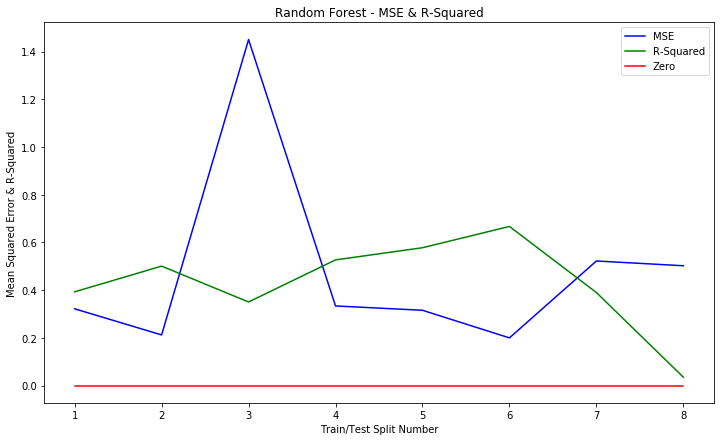

rf_r2:  [0.3926610563849764, 0.5004292852826402, 0.35013350090439, 0.5265174831205931, 0.5774937528008133, 0.6667425573851893, 0.3896884275318595, 0.03487131340210714]
[0.06527781 0.0375729  0.02268795 0.02113029 0.01981762 0.01018788
 0.01020962 0.01221726 0.00616326 0.00551913 0.00731331 0.00698486
 0.01352864 0.25676191 0.00224986 0.00203176 0.0027929  0.00190598
 0.00454462 0.00260688 0.00810347 0.17741336 0.01468695 0.00815622
 0.01807169 0.00664548 0.05207222 0.00898921 0.02359875 0.009196
 0.01547653 0.01959196 0.00299902 0.01044706 0.03813603 0.0080121
 0.03023646 0.00520651 0.00457602 0.00744245 0.00901926 0.01041883]


In [104]:
"""
Execute Random Forest for differnt number of Time Series Splits
"""
def Call_Random_Forest(numSplits):
    ### Prepare Random Forest
    ##############################################################################
    # Initialize Random Forest Instance
    rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, random_state=123, min_samples_split=10, max_depth=None)

    rf_mse = [] # MSE
    rf_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

        # Print Statements
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Split: ", splitCount)
        print('Observations: ', (X_train.shape[0] + X_val.shape[0]))
        #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
        print('Training Observations: ', (X_train.shape[0]))
        print('Testing Observations: ', (X_val.shape[0]))
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        rf.fit(X_train, y_train)
        prediction = rf.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        rf_mse.append(mse)
        rf_r2.append(r2)

    # print("rf_mse: ", rf_mse)
    # print("rf_r2: ", rf_r2)



    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Random Forest - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), rf_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), rf_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()
    print("rf_r2: ", rf_r2)
    print(rf.feature_importances_)

############
Call_Random_Forest(8)

### Bagging

In [96]:
"""
Execute Bagging for differnt number of Time Series Splits
"""
def Call_Bagging(numSplits):
    ### Prepare Bagging
    ##############################################################################
    # Initialize Bagging Instance
    bagging = BaggingRegressor(n_estimators=150, n_jobs=-1, random_state=123)

    bagging_mse = [] # MSE
    bagging_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        bagging.fit(X_train, y_train)
        prediction = bagging.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        bagging_mse.append(mse)
        bagging_r2.append(r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Bagging - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), bagging_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), bagging_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()
    print("bagging_r2: ", bagging_r2)



### Boosting

In [81]:
"""
Execute Random Forest for differnt number of Time Series Splits
"""
def Call_Boosting(numSplits):
    ### Prepare Boosting
    ##############################################################################
    # Initialize Boosting Instance    
    boosting = AdaBoostRegressor(DecisionTreeRegressor(),
                                 n_estimators=150, random_state=123,learning_rate=0.01)

    boosting_mse = [] # MSE
    boosting_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        boosting.fit(X_train, y_train)
        prediction = boosting.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)

        boosting_mse.append(mse)
        boosting_r2.append(r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Boosting - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), boosting_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), boosting_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()
    print("boosting_r2: ", boosting_r2)



### Linear Regression


In [82]:
"""
Execute Linear Regression for different number of Time Series Splits
"""
def Call_Linear(numSplits):
    ### Prepare Random Forest
    ##############################################################################
    # Initialize Random Forest Instance
    linear = LinearRegression(n_jobs=-1, normalize=True, fit_intercept=False) # if we don't fit the intercept we get a better prediction

    linear_mse = [] # MSE
    linear_r2 = [] # R2


    ### Time Series Split
    ##############################################################################
    splits = TimeSeriesSplit(n_splits=numSplits) # 3 splits

    splitCount = 0 # dummy count var to track current split num in print statements
    for train_index, test_index in splits.split(X_train_all):
        splitCount += 1 

        # Train Split
        X_train = X_train_all.iloc[train_index,:]
        y_train = y[X_train.index]

        # Validate Split
        X_val = X_train_all.iloc[test_index,:]
        y_val = y[X_val.index]

#         # Print Statements
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
#         print("Split: ", splitCount)
#         print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
#         #print('Cutoff date, or first date in validation data: ', X_val.iloc[0,0])
#         print('Training Observations: ', (X_train.shape[0]))
#         print('Testing Observations: ', (X_test.shape[0]))
#         print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

        ### Run Random Forest
        linear.fit(X_train, y_train)
        prediction = linear.predict(X_val)

        mse = mean_squared_error(y_val, prediction)
        r2  = r2_score(y_val, prediction)
        r2 = np.corrcoef(y_val, prediction)[0, 1] 
        r2 = r2*r2 # square of correlation coefficient --> R-squared

        linear_mse.append(mse)
        linear_r2.append(r2)


    ### Time Series Split
    ##############################################################################
    # Plot the chart of MSE versus number of estimators
    plt.figure(figsize=(12, 7))
    plt.title('Linear Regression - MSE & R-Squared')

    ### MSE
    plt.plot(list(range(1,splitCount+1)), linear_mse, 'b-', color="blue", label='MSE')
    plt.plot(list(range(1,splitCount+1)), linear_r2, 'b-', color="green", label='R-Squared')
    plt.plot(list(range(1,splitCount+1)), np.array([0] * splitCount), 'b-', color="red", label='Zero')


    plt.legend(loc='upper right')
    plt.xlabel('Train/Test Split Number')
    plt.ylabel('Mean Squared Error & R-Squared')
    plt.show()
    print("linear_r2: ", linear_r2)



### Misc. Graphs ---- Price, Returns & Cumulative Returns

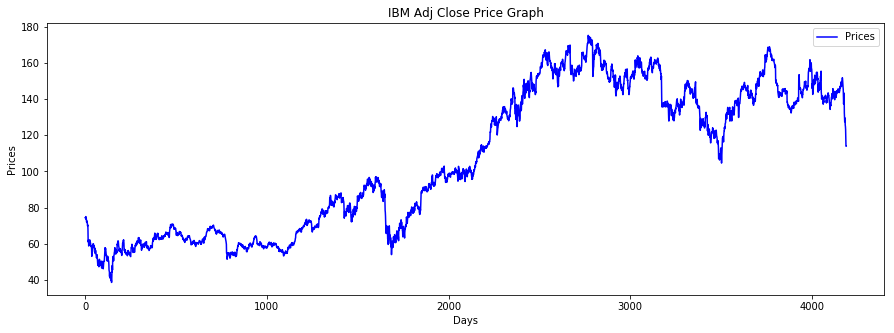

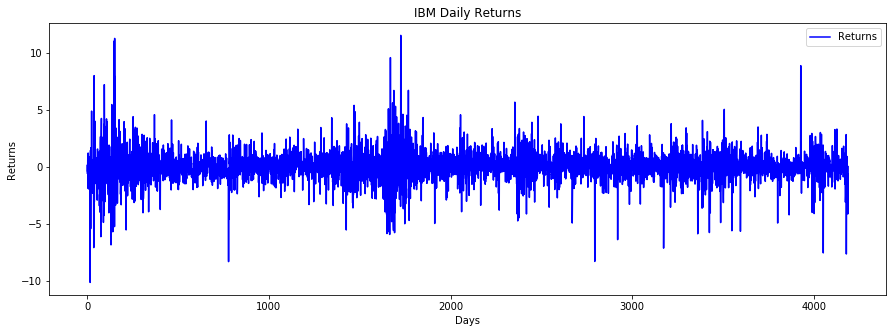

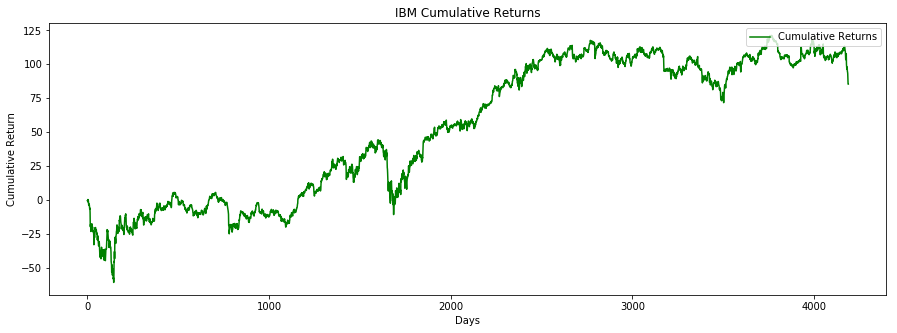

In [67]:
# figure dimenstions
length = 15
height = 5

### Prices
plt.figure(figsize=(length, height))
plt.title('IBM Adj Close Price Graph')
plt.plot(daily_index, daily_price, 'b-', color="blue", label='Prices')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Prices')
plt.show()

### Returns
plt.figure(figsize=(length, height))
plt.title('IBM Daily Returns')
plt.plot(daily_index, daily_returns, 'b-', color="blue", label='Returns')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Returns')
plt.show()

### Cumulative Returns
plt.figure(figsize=(length, height))
plt.title('IBM Cumulative Returns')
cumulative_returns = daily_returns.cumsum()
plt.plot(daily_index, cumulative_returns, 'b-', color="green", label='Cumulative Returns')
plt.legend(loc='upper right')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.show()


### First - A Note on R-Squared

##### What Does A Negative R Squared Value Mean?

- What does R-squared tell us?
    - It tells us whether a horizonal line through the vertical mean of the data is a better predictor
- For a Linear Regression
    - R-squared is just the coreelation coefficient squared
    - R-squared can't be negative, becasue at 0, it becomes the horizontal line
- For All other Model
    - For practical purposes, the lowest R2 you can get is zero, but only because the assumption is that if your regression line is not better than using the mean, then you will just use the mean value.  
    - However if your regression line is worse than using the mean value, the r squared value that you calculate will be negative.
    - Note that the reason R2 can't be negative in the linear regression case is just due to chance and how linear regression is contructed
    
##### Note
- In our R2 computation for the linear model, we're still getting a negative R2, not sure why

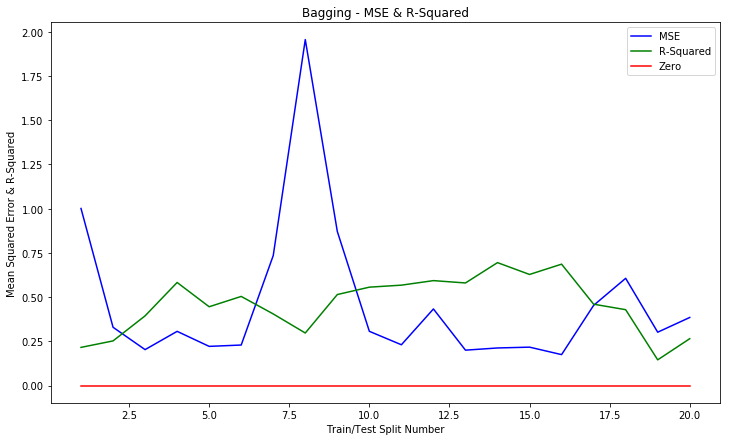

bagging_r2:  [0.21547135846259025, 0.25207980956764986, 0.39365108875263977, 0.5823414253561121, 0.4451294633530797, 0.5034921670707303, 0.4045154384847385, 0.2966906449258606, 0.5141345477399863, 0.5558453276350038, 0.567183446813127, 0.5928255976989533, 0.5796085840543477, 0.6945397627592311, 0.627628271493412, 0.6858652715703498, 0.4595879117151219, 0.42850056971953565, 0.14501842792619324, 0.2645650161639518]


In [97]:
#Call_Random_Forest(20) 
Call_Bagging(20) 
# Call_Boosting(20) # takes forever to run


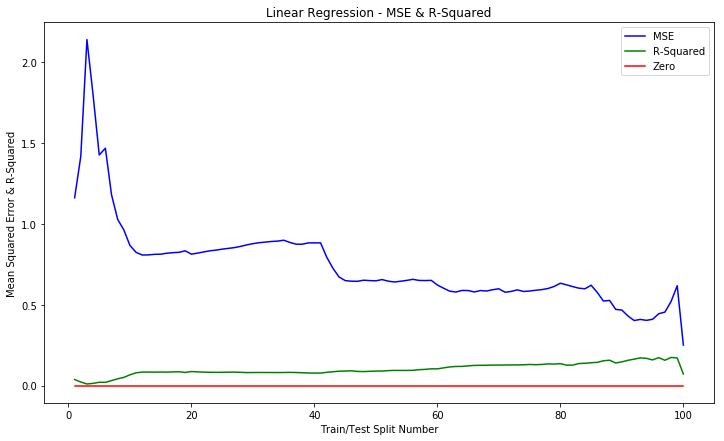

In [101]:
Call_Linear(100)

0.7071067811865476

In [92]:
X.columns


Index(['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'STD_14', 'RSI_14', 'ADX_14_13',
       'MA_21', 'EMA_21', 'Momentum_14', 'ATR_14', 'BollingerB_21',
       'Bollinger%b_21', 'PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3', 'SO%k',
       'SO%d_14', 'Trix_14', 'MACD_26_12', 'MACDsign_26_12', 'MACDdiff_26_12',
       'Mass Index', 'Vortex_14', 'KST_10_10_10_15_10_15_20_30', 'TSI_25_13',
       'Chaikin', 'MFI_14', 'OBV_14', 'Force_14', 'EoM_14', 'CCI_14',
       'KelChM_14', 'KelChU_14', 'KelChD_14', 'Ultimate_Osc', 'Donchian_14'],
      dtype='object')